In [1]:
import pandas as pd
import numpy as np
import os

# body

In [2]:
body = pd.read_csv('/share/pub/zhangyr/database/UKB-old//body_fileID_20241216.csv',header=0)
age = pd.read_csv('/share2/pub/zhangyr/zhangyr/myIdea/bioAge/data/UKB/body/502137_age_20241226.csv',header=0,index_col=0)
sex = pd.read_csv('/share2/pub/zhangyr/zhangyr/myIdea/bioAge/data/UKB/body/502137_sex_20241226.csv',header=0,index_col=0)
age

,participant.p21022
participant.eid,
1000019.0,62.0
1000022.0,59.0
1000035.0,56.0
1000046.0,59.0
1000054.0,42.0
...,...
6023625.0,53.0
6023638.0,64.0
6023642.0,64.0


In [27]:
age = pd.read_csv('/share/pub/zhangyr/database/UKB/birth_age_20250213.csv',index_col=0)
age = pd.DataFrame(age['age_i0'])
age

,age_i0
eid,
1000019.0,62.751540
1000022.0,59.780972
1000035.0,55.991786
1000046.0,59.433265
1000054.0,42.360027
...,...
6023625.0,53.557837
6023638.0,63.827515
6023642.0,63.312799


In [3]:
baseline = pd.read_csv('/share2/pub/zhangyr/zhangyr/myIdea/bioAge/data/UKB/body/502137_baseline_78features_20241226.csv',header=0,index_col=0)
baseline.shape

(502137, 78)

In [4]:
grouped_dict = body.groupby('Organ')['Filed ID'].apply(list).to_dict()
organ_dic = {}
for k in grouped_dict:
    if k != 'Body':
        organ_dic[k] = ['participant.p'+str(x)+'_i0' for x in grouped_dict[k]]

organ_dic['Pulmonary'] = organ_dic['Pulmonary']+['FEV1-FVC_ratio']
organ_dic['Musculoskeletal'] = organ_dic['Musculoskeletal']+['Waist-hip_ratio','BMD_avg','Ankle_spacing_width_avg','Hand_grip_strength_avg']
organ_dic

{'Cardiovascular': ['participant.p102_i0',
  'participant.p4079_i0',
  'participant.p4080_i0'],
 'Hepatic': ['participant.p30600_i0',
  'participant.p30610_i0',
  'participant.p30620_i0',
  'participant.p30650_i0',
  'participant.p30660_i0',
  'participant.p30730_i0',
  'participant.p30840_i0',
  'participant.p30860_i0'],
 'Immune': ['participant.p30000_i0',
  'participant.p30010_i0',
  'participant.p30020_i0',
  'participant.p30030_i0',
  'participant.p30040_i0',
  'participant.p30050_i0',
  'participant.p30060_i0',
  'participant.p30070_i0',
  'participant.p30080_i0',
  'participant.p30090_i0',
  'participant.p30100_i0',
  'participant.p30110_i0',
  'participant.p30120_i0',
  'participant.p30130_i0',
  'participant.p30140_i0',
  'participant.p30150_i0',
  'participant.p30160_i0',
  'participant.p30170_i0',
  'participant.p30180_i0',
  'participant.p30190_i0',
  'participant.p30200_i0',
  'participant.p30210_i0',
  'participant.p30220_i0',
  'participant.p30230_i0',
  'participant.p30

## icd9、icd10、self report均没有疾病

In [13]:
health_eid = pd.read_csv('/share/pub/zhangyr/database/UKB/health_i0_62104.csv',header=0)
health_eid.head()

,participant.eid
0,1000081
1,1000112
2,1000203
3,1000236
4,1000304


## 之前：没有16种慢病的为正常人

In [5]:
health_eid = pd.read_csv('/share/pub/zhangyr/database/UKB/health_self_icd10.csv',header=0)
health_eid.shape

(249125, 1)

In [65]:
health_eid_old = pd.read_csv('/share/pub/zhangyr/database/UKB/health.csv',header=0)
health_eid_old.shape

(276730, 1)

## 提取正常人的矩阵

In [8]:
#health_data = baseline.loc[health_eid['participant.eid']].dropna()
health_data = baseline.loc[health_eid['eid']].dropna()
health_data.shape

(65048, 78)

In [9]:
from sklearn.svm import SVR
from sklearn.utils.validation import column_or_1d
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors 
from scipy.stats import pearsonr

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


def runSVM(x, y, p_eids, kfold =5):
    svr = make_pipeline(StandardScaler(), SVR(kernel='linear'))
    kf = KFold(n_splits=kfold, shuffle=True, random_state=123)
    mae_scores = []
    pearson_scores = []
    predicted_y = []
    true_y = []
    samples = []
    for train_index, test_index in kf.split(x):
        print(train_index.shape)
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        samples += list(p_eids[test_index])
                
        svr.fit(x_train, y_train)
        predictions = svr.predict(x_test)
        
        predicted_y += list(predictions)
        true_y += list(y_test)
        
        mae = mean_absolute_error(y_test, predictions)
        #print(mae)
        mae_scores+=[mae]
        
        r, _ = pearsonr(y_test, predictions)
        #print(r)
        pearson_scores+=[r]
        
    res_dic = {'true_y':true_y,
               'predicted_y':predicted_y,
               'mae_scores':mae_scores,
               'pearson_scores':pearson_scores,
               'eids':samples
                  }
    return res_dic
    
def plotRes(res,figfolder,sex,organ,num_features):
    plt.figure(figsize=(5, 4))
    plt.hist2d(res['true_y'], res['predicted_y'], bins=30, cmap="viridis", norm = colors.LogNorm())
    plt.xlabel('Chronological age (years)',fontsize=12)
    plt.ylabel('Predicted age (years)',fontsize=12)
    plt.title(sex+': '+organ+' ('+str(num_features)+' features)')
    plt.xlim(30,90)
    plt.ylim(30,90)

    m, b = np.polyfit(res['true_y'], res['predicted_y'], 1)  # 线性拟合
    plt.plot(res['true_y'], m * np.array(res['true_y']) + b, color='red', label='Fit line')

    plt.text(65, 35, f"r = {np.mean(res['pearson_scores']):.2f}\nMAE = {np.mean(res['mae_scores']):.2f}", 
             fontsize=12, color='black')
    plt.savefig(figfolder+sex+'_'+organ+'_'+str(num_features)+'features_20241226.pdf',format="pdf")

In [30]:
test_age = age.loc[health_data.index]
test_sex = sex.loc[health_data.index]

In [31]:
test_sex

,participant.p31
participant.eid,
1000081.0,1.0
1000186.0,1.0
1000203.0,0.0
1000331.0,1.0
1000362.0,1.0
...,...
6023203.0,1.0
6023224.0,1.0
6023269.0,0.0


In [32]:
female_x = health_data[test_sex.values == 0].values
female_y = test_age[test_sex.values == 0].values.ravel()
eids = health_data.index[test_sex.values.ravel() == 0]

In [33]:
female_y

array([61.60985626, 64.29568789, 51.41957563, ..., 44.85147159,
       56.23271732, 63.31279945])

In [34]:
female_res = runSVM(female_x, female_y,eids)
print("Average MAE:", np.mean(female_res['mae_scores']))
print("Average Pearson r:", np.mean(female_res['pearson_scores']))

(24987,)
(24987,)
(24987,)
(24987,)
(24988,)
Average MAE: 3.9552065326584263
Average Pearson r: 0.7822599766504861


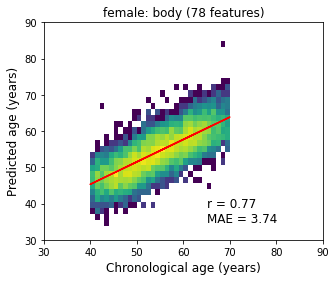

In [15]:
plotRes(female_res,
        #'/share2/pub/zhangyr/zhangyr/myIdea/bioAge/results/svm-body/',
        '/share2/pub/zhangyr/zhangyr/myIdea/bioAge/figures/svm-body/2025/',
                'female',
                'body',
                female_x.shape[1])

In [16]:
male_x = health_data[test_sex.values == 1].values
male_y = test_age[test_sex.values == 1].values.ravel()
eids = health_data.index[test_sex.values.ravel() == 1]
male_res = runSVM(male_x, male_y,eids)
print("Average MAE:", np.mean(male_res['mae_scores']))
print("Average Pearson r:", np.mean(male_res['pearson_scores']))

(7562,)
(7562,)
(7562,)
(7563,)
(7563,)
Average MAE: 4.537978162848941
Average Pearson r: 0.7083477550725779


In [18]:
male_x.shape[1]

78

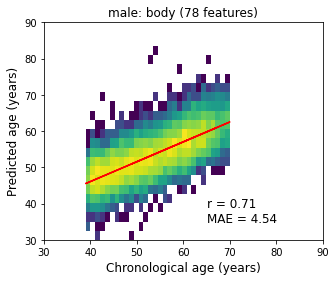

In [20]:
plotRes(male_res,
        #'/share2/pub/zhangyr/zhangyr/myIdea/bioAge/results/svm-body/',
        '/share2/pub/zhangyr/zhangyr/myIdea/bioAge/figures/svm-body/2025/',
                'male',
                'body',
                male_x.shape[1])

In [21]:
organ_res = {}
organ_res['body'] = {'female_res':female_res,
                     'male_res':male_res
                    }

In [22]:
for k in organ_dic:
    print(k)
    health_organ_data = health_data[set(health_data.columns) & set(organ_dic[k])]
    print(health_organ_data.shape)
    test_age = age.loc[health_organ_data.index]
    test_sex = sex.loc[health_organ_data.index]
    
    female_x = health_organ_data[test_sex.values == 0].values
    female_y = test_age[test_sex.values == 0].values.ravel()
    eids = health_data.index[test_sex.values.ravel() == 0]
    female_res = runSVM(female_x, female_y, eids)
    #plotRes(organ_res['female_res'],
    #            '/share2/pub/zhangyr/zhangyr/myIdea/bioAge/results/svm-body/',
    #            'female',
    #            k,
    #            health_organ_data.shape[1]
    #           )
    
    male_x = health_organ_data[test_sex.values == 1].values
    male_y = test_age[test_sex.values == 1].values.ravel()
    eids = health_data.index[test_sex.values.ravel() == 1]
    male_res = runSVM(male_x, male_y, eids)
    #plotRes(organ_res['male_res'],
    #            '/share2/pub/zhangyr/zhangyr/myIdea/bioAge/results/svm-body/',
    #            'male',
    #            k,
    #            health_organ_data.shape[1]
    #           )
    organ_res[k] = {
        'female_res':female_res,
        'male_res':male_res
    }

Cardiovascular
(16557, 3)
(5683,)


/tmp/ipykernel_394165/4207711514.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  health_organ_data = health_data[set(health_data.columns) & set(organ_dic[k])]


(5683,)
(5683,)
(5683,)
(5684,)
(7562,)
(7562,)
(7562,)
(7563,)
(7563,)
Hepatic
(16557, 8)
(5683,)


/tmp/ipykernel_394165/4207711514.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  health_organ_data = health_data[set(health_data.columns) & set(organ_dic[k])]


(5683,)
(5683,)
(5683,)
(5684,)
(7562,)
(7562,)
(7562,)
(7563,)
(7563,)
Immune
(16557, 32)
(5683,)


/tmp/ipykernel_394165/4207711514.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  health_organ_data = health_data[set(health_data.columns) & set(organ_dic[k])]


(5683,)
(5683,)
(5683,)
(5684,)
(7562,)
(7562,)
(7562,)
(7563,)
(7563,)
Metabolic
(16557, 9)
(5683,)


/tmp/ipykernel_394165/4207711514.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  health_organ_data = health_data[set(health_data.columns) & set(organ_dic[k])]


(5683,)
(5683,)
(5683,)
(5684,)
(7562,)
(7562,)
(7562,)
(7563,)
(7563,)
Musculoskeletal
(16557, 11)
(5683,)


/tmp/ipykernel_394165/4207711514.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  health_organ_data = health_data[set(health_data.columns) & set(organ_dic[k])]


(5683,)
(5683,)
(5683,)
(5684,)
(7562,)
(7562,)
(7562,)
(7563,)
(7563,)
Pulmonary
(16557, 4)
(5683,)


/tmp/ipykernel_394165/4207711514.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  health_organ_data = health_data[set(health_data.columns) & set(organ_dic[k])]


(5683,)
(5683,)
(5683,)
(5684,)
(7562,)
(7562,)
(7562,)
(7563,)
(7563,)
Renal
(16557, 10)
(5683,)


/tmp/ipykernel_394165/4207711514.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  health_organ_data = health_data[set(health_data.columns) & set(organ_dic[k])]


(5683,)
(5683,)
(5683,)
(5684,)
(7562,)
(7562,)
(7562,)
(7563,)
(7563,)


In [23]:
for k in organ_res:
    print(k)

body
Cardiovascular
Hepatic
Immune
Metabolic
Musculoskeletal
Pulmonary
Renal


In [24]:
np.save('/share2/pub/zhangyr/zhangyr/myIdea/bioAge/results/body/SVM_7organ_body_20250211.npy',organ_res)

In [132]:
np.save('/share2/pub/zhangyr/zhangyr/myIdea/bioAge/results/body/SVM_7organ_body_20241227.npy',organ_res)

In [25]:
rs = []
sexs = []
maes = []
organs = []
for k in organ_res:
    rs+=[np.mean(organ_res[k]['female_res']['pearson_scores'])]
    maes+=[np.mean(organ_res[k]['female_res']['mae_scores'])]
    sexs+=['Female']
    organs+=[k]
    rs+=[np.mean(organ_res[k]['male_res']['pearson_scores'])]
    maes+=[np.mean(organ_res[k]['male_res']['mae_scores'])]
    sexs+=['Male']
    organs+=[k]

In [27]:
plot_df = pd.DataFrame({'Correlation':rs,
                        'MAE':maes,
                        'Gender':sexs,
                        'Organ':organs
                       })
plot_df

,Correlation,MAE,Gender,Organ
0,0.771981,3.743529,Female,body
1,0.708348,4.537978,Male,body
2,0.417345,5.567514,Female,Cardiovascular
3,0.340116,6.324869,Male,Cardiovascular
4,0.427525,5.446426,Female,Hepatic
5,0.331427,6.338794,Male,Hepatic
6,0.273987,5.901146,Female,Immune
7,0.299919,6.432629,Male,Immune
8,0.463346,5.345393,Female,Metabolic
9,0.240540,6.587431,Male,Metabolic


<AxesSubplot: xlabel='Organ', ylabel='Correlation'>

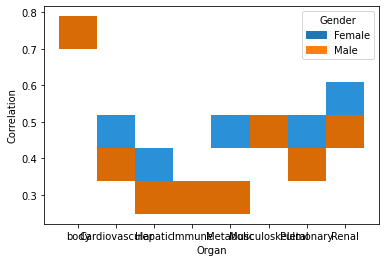

In [138]:
sns.histplot(data=plot_df, 
             x="Organ", hue="Gender",y='Correlation', multiple="stack")

In [137]:
plot_df.to_csv('/share2/pub/zhangyr/zhangyr/myIdea/bioAge/results/body/df_r_mae_body.csv')

In [28]:
plot_df.to_csv('/share2/pub/zhangyr/zhangyr/myIdea/bioAge/results/body/df_r_mae_body_20250211.csv')

# Brain

In [29]:
brain = pd.read_csv('/share2/pub/zhangyr/zhangyr/myIdea/bioAge/data/UKB/brain/502137_baseline_803features_20241226.csv',index_col=0)
brain

,participant.p25056_i2,participant.p25057_i2,participant.p25058_i2,participant.p25059_i2,participant.p25060_i2,participant.p25061_i2,participant.p25062_i2,participant.p25063_i2,participant.p25064_i2,participant.p25065_i2,...,participant.p27763_i2,participant.p27764_i2,participant.p27765_i2,participant.p27766_i2,participant.p27767_i2,participant.p27768_i2,participant.p27769_i2,participant.p27770_i2,participant.p27771_i2,participant.p27772_i2
participant.eid,,,,,,,,,,,,,,,,,,,,,
1000019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6023625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6023638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6023642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
health_eid.head()

,participant.eid
0,1000081
1,1000112
2,1000203
3,1000236
4,1000304


In [32]:
health_brain = brain.loc[health_eid['participant.eid']].dropna()
health_brain.shape

(7037, 803)

In [33]:
f = 'Xulab_11.csv'
folder = '/share/pub/zhangyr/database/UKB/output/'
data = pd.read_csv(os.path.join(folder, f),index_col=0)
pattern = 'participant\\.p21003_.+'
cols_bollen = data.columns.str.contains(pattern, regex=True)
age_time = data.loc[:,cols_bollen]
age_time

/tmp/ipykernel_394165/4014612169.py:3: DtypeWarning: Columns (36,38,44,46,54,56,62,64,68,70,80,86,92,94,98,123) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(os.path.join(folder, f),index_col=0)


,participant.p21003_i0,participant.p21003_i1,participant.p21003_i2,participant.p21003_i3
participant.eid,,,,
1000019.0,62.0,NaN,NaN,NaN
1000022.0,59.0,NaN,NaN,NaN
1000035.0,56.0,NaN,NaN,NaN
1000046.0,59.0,NaN,NaN,NaN
1000054.0,42.0,NaN,NaN,NaN
...,...,...,...,...
NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN


In [34]:
test_age = age_time['participant.p21003_i2'].loc[health_brain.index]
test_sex = sex.loc[health_brain.index]

In [35]:
female_x = health_brain[test_sex.values == 0].values
female_y = test_age[test_sex.values.ravel() == 0].values.ravel()
eids = health_brain.index[test_sex.values.ravel() == 0]

In [36]:
female_y.shape

(3384,)

In [37]:
female_res = runSVM(female_x, female_y,eids)
print("Average MAE:", np.mean(female_res['mae_scores']))
print("Average Pearson r:", np.mean(female_res['pearson_scores']))

(2707,)
(2707,)
(2707,)
(2707,)
(2708,)
Average MAE: 3.5001082364074456
Average Pearson r: 0.7905571588795796


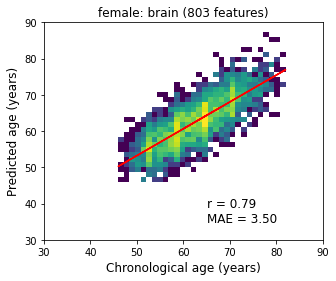

In [38]:
plotRes(female_res,
        #'/share2/pub/zhangyr/zhangyr/myIdea/bioAge/figures/svm-brain/',
        '/share2/pub/zhangyr/zhangyr/myIdea/bioAge/figures/svm-brain/2025/',
                'female',
                'brain',
                female_x.shape[1])

In [39]:
male_x = health_brain[test_sex.values == 1].values
male_y = test_age[test_sex.values.ravel() == 1].values.ravel()
eids = health_brain.index[test_sex.values.ravel() == 1]
male_res = runSVM(male_x, male_y,eids)
print("Average MAE:", np.mean(male_res['mae_scores']))
print("Average Pearson r:", np.mean(male_res['pearson_scores']))

(2922,)
(2922,)
(2922,)
(2923,)
(2923,)
Average MAE: 3.491036406959549
Average Pearson r: 0.8293376955198137


In [40]:
print("Average MAE:", np.mean(male_res['mae_scores']))
print("Average Pearson r:", np.mean(male_res['pearson_scores']))

Average MAE: 3.491036406959549
Average Pearson r: 0.8293376955198137


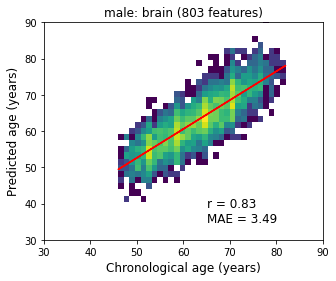

In [42]:
plotRes(male_res,
        #'/share2/pub/zhangyr/zhangyr/myIdea/bioAge/figures/svm-brain/',
        '/share2/pub/zhangyr/zhangyr/myIdea/bioAge/figures/svm-brain/2025/',
                'male',
                'brain',
                female_x.shape[1])

In [43]:
brain_res = {}
brain_res['brain'] = {'female_res':female_res,
                     'male_res':male_res
                    }

In [44]:
np.save('/share2/pub/zhangyr/zhangyr/myIdea/bioAge/results/body/SVM_brain_803features_20250211.npy',brain_res)

In [258]:
np.save('/share2/pub/zhangyr/zhangyr/myIdea/bioAge/results/body/SVM_brain_803features_20241227.npy',brain_res)

In [47]:
all_res = organ_res

In [48]:
all_res['brain'] = brain_res['brain']

In [49]:
for o in all_res:
    print(o)

body
Cardiovascular
Hepatic
Immune
Metabolic
Musculoskeletal
Pulmonary
Renal
brain


# Eye

In [50]:
eye = pd.read_csv('/share2/pub/zhangyr/zhangyr/myIdea/bioAge/data/UKB/eye/502137_baseline_152features_20241227.csv',index_col=0)
eye

,participant.p5185_i0,participant.p5186_i0,participant.p5187_i0,participant.p5188_i0,participant.p5190_i0,participant.p5193_i0,participant.p5199_i0,participant.p5200_i0,participant.p5201_i0,participant.p5202_i0,...,participant.p28544_i0,participant.p28545_i0,participant.p28546_i0,participant.p28547_i0,participant.p28548_i0,participant.p28549_i0,participant.p28550_i0,participant.p28551_i0,participant.p28552_i0,participant.p28553_i0
participant.eid,,,,,,,,,,,,,,,,,,,,,
1000019.0,1.0,89.0,1.0,148.0,193.0,253.0,-0.1,5.0,-0.08,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000022.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000035.0,1.0,9.0,1.0,79.0,122.0,163.0,0.2,5.0,0.06,4.0,...,450.0,961.0,0.976016,0.950999,0.955078,2.53711,0.0,0.00000,69.7668,70.5140
1000046.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000054.0,1.0,9.0,1.0,53.0,75.0,116.0,-0.2,5.0,-0.10,2.0,...,930.0,961.0,0.976314,0.682629,1.216800,3.49414,0.0,3.49414,76.1145,74.0454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6023625.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6023638.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6023642.0,1.0,95.0,1.0,172.0,NaN,NaN,0.3,5.0,0.34,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
for c in eye.columns:
    try:
        eye[c] = eye[c].astype(float)
    except:
        print(c)

participant.p5258_i0
participant.p5259_i0
participant.p5266_i0
participant.p5267_i0


In [52]:
remove_f = ['participant.p5258_i0','participant.p5259_i0','participant.p5266_i0','participant.p5267_i0']
eye = eye[set(eye.columns)-set(remove_f)]
eye.shape

/tmp/ipykernel_394165/4170692374.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  eye = eye[set(eye.columns)-set(remove_f)]


(502137, 148)

In [53]:
health_eid.head()

,participant.eid
0,1000081
1,1000112
2,1000203
3,1000236
4,1000304


In [54]:
health_eye = eye.loc[health_eid['participant.eid']]
health_eye.shape

(62104, 148)

In [55]:
aa = (1-health_eye.isna().mean(0).sort_values())*249125
aa

participant.p5187_i0     54342.657075
participant.p5188_i0     54342.657075
participant.p5185_i0     54338.645659
participant.p5186_i0     54338.645659
participant.p5204_i0     54234.348834
                             ...     
participant.p27820_i0     9129.983576
participant.p27858_i0     1865.308595
participant.p27856_i0     1865.308595
participant.p27852_i0     1339.813056
participant.p27854_i0     1339.813056
Length: 148, dtype: float64

In [56]:
health_eye[aa.index[0:121]].dropna().shape

(1609, 121)

In [57]:
health_eye = health_eye[aa.index[0:120]].dropna()
health_eye.shape

(2159, 120)

In [58]:
test_age = age_time['participant.p21003_i0'].loc[health_eye.index]
test_sex = sex.loc[health_eye.index]

In [59]:
female_x = health_eye[test_sex.values == 0].values
female_y = test_age[test_sex.values.ravel() == 0].values.ravel()
eids = health_eye.index[test_sex.values.ravel() == 0]

In [60]:
female_y.shape

(1086,)

In [61]:
female_res = runSVM(female_x, female_y,eids)
print("Average MAE:", np.mean(female_res['mae_scores']))
print("Average Pearson r:", np.mean(female_res['pearson_scores']))

(868,)
(869,)
(869,)
(869,)
(869,)
Average MAE: 5.818557222234669
Average Pearson r: 0.4211594975585239


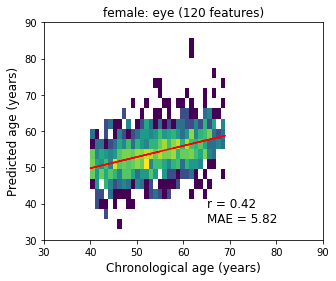

In [62]:
plotRes(female_res,
        #'/share2/pub/zhangyr/zhangyr/myIdea/bioAge/figures/svm-eye/',
        '/share2/pub/zhangyr/zhangyr/myIdea/bioAge/figures/svm-eye/2025/',
                'female',
                'eye',
                female_x.shape[1])

In [63]:
male_x = health_eye[test_sex.values == 1].values
male_y = test_age[test_sex.values.ravel() == 1].values.ravel()
eids = health_eye.index[test_sex.values.ravel() == 1]
male_res = runSVM(male_x, male_y,eids)
print("Average MAE:", np.mean(male_res['mae_scores']))
print("Average Pearson r:", np.mean(male_res['pearson_scores']))

(858,)
(858,)
(858,)
(859,)
(859,)
Average MAE: 6.431028644747558
Average Pearson r: 0.35092697181994437


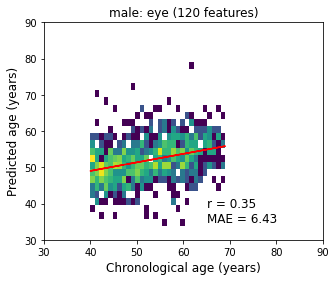

In [64]:
plotRes(male_res,
        #'/share2/pub/zhangyr/zhangyr/myIdea/bioAge/figures/svm-eye/',
        '/share2/pub/zhangyr/zhangyr/myIdea/bioAge/figures/svm-eye/2025/',
                'male',
                'eye',
                female_x.shape[1])

In [65]:
eye_res = {}
eye_res['eye-meatures'] = {'female_res':female_res,
                     'male_res':male_res
                    }
np.save('/share2/pub/zhangyr/zhangyr/myIdea/bioAge/results/eye/SVM_eye_120features_20250211.npy',eye_res)
#np.save('/share2/pub/zhangyr/zhangyr/myIdea/bioAge/results/eye/SVM_eye_120features_20241227.npy',eye_res)

In [66]:
all_res['eye-meatures'] = eye_res['eye-meatures']

In [67]:
for o in all_res:
    print(o)

body
Cardiovascular
Hepatic
Immune
Metabolic
Musculoskeletal
Pulmonary
Renal
brain
eye-meatures


In [68]:
rs = []
sexs = []
maes = []
organs = []
for k in all_res:
    rs+=[np.mean(all_res[k]['female_res']['pearson_scores'])]
    maes+=[np.mean(all_res[k]['female_res']['mae_scores'])]
    sexs+=['Female']
    organs+=[k]
    rs+=[np.mean(all_res[k]['male_res']['pearson_scores'])]
    maes+=[np.mean(all_res[k]['male_res']['mae_scores'])]
    sexs+=['Male']
    organs+=[k]

In [69]:
plot_df = pd.DataFrame({'Correlation':rs,
                        'MAE':maes,
                        'Gender':sexs,
                        'Organ':organs
                       })
plot_df

,Correlation,MAE,Gender,Organ
0,0.771981,3.743529,Female,body
1,0.708348,4.537978,Male,body
2,0.417345,5.567514,Female,Cardiovascular
3,0.340116,6.324869,Male,Cardiovascular
4,0.427525,5.446426,Female,Hepatic
5,0.331427,6.338794,Male,Hepatic
6,0.273987,5.901146,Female,Immune
7,0.299919,6.432629,Male,Immune
8,0.463346,5.345393,Female,Metabolic
9,0.240540,6.587431,Male,Metabolic


In [70]:
plot_df.to_csv('/share2/pub/zhangyr/zhangyr/myIdea/bioAge/results/df_r_mae_body+brain+eye_20250211.csv')

In [297]:
plot_df.to_csv('/share2/pub/zhangyr/zhangyr/myIdea/bioAge/results/df_r_mae_body+brain+eye_20241227.csv')

In [298]:
plot_df.sort_values(['Correlation'])

,Correlation,MAE,Gender,Organ
9,0.247748,6.777763,Male,Metabolic
6,0.283726,6.377400,Female,Immune
7,0.299835,6.616212,Male,Immune
5,0.324848,6.549652,Male,Hepatic
3,0.341154,6.510527,Male,Cardiovascular
13,0.411349,6.270881,Male,Pulmonary
4,0.428114,5.881138,Female,Hepatic
11,0.430543,6.172662,Male,Musculoskeletal
19,0.434628,6.266889,Male,eye-meatures
2,0.449277,5.922155,Female,Cardiovascular


# eye-3nd

In [299]:
eye = pd.read_csv('/share2/pub/zhangyr/zhangyr/myIdea/bioAge/data/UKB/eye/502137_3ndFollow_53features_20241227.csv',index_col=0)
eye

,participant.p6070_i2,participant.p6071_i2,participant.p6072_i2,participant.p6073_i2,participant.p7486_i2,participant.p7494_i2,participant.p7495_i2,participant.p7496_i2,participant.p7497_i2,participant.p7498_i2,...,participant.p7534_i2,participant.p7535_i2,participant.p7536_i2,participant.p7537_i2,participant.p7538_i2,participant.p7539_i2,participant.p7541_i2,participant.p7542_i2,participant.p7544_i2,participant.p20261
participant.eid,,,,,,,,,,,,,,,,,,,,,
1000019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.407500
1000022.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000035.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.590833
1000046.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000054.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.072500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6023625.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6023638.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6023642.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [300]:
for c in eye.columns:
    try:
        eye[c] = eye[c].astype(float)
    except:
        print(c)

In [301]:
health_eye = eye.loc[health_eid['eid']]
health_eye.shape

(249125, 53)

In [302]:
aa = (1-health_eye.isna().mean(0).sort_values())*249125
aa

participant.p20261      57457.0
participant.p6073_i2     1178.0
participant.p6070_i2     1178.0
participant.p6071_i2     1178.0
participant.p6072_i2     1178.0
participant.p7486_i2     1035.0
participant.p7494_i2     1035.0
participant.p7541_i2     1030.0
participant.p7527_i2     1030.0
participant.p7526_i2     1030.0
participant.p7525_i2     1030.0
participant.p7524_i2     1030.0
participant.p7523_i2     1030.0
participant.p7522_i2     1030.0
participant.p7521_i2     1030.0
participant.p7520_i2     1030.0
participant.p7519_i2     1030.0
participant.p7518_i2     1030.0
participant.p7517_i2     1030.0
participant.p7498_i2     1028.0
participant.p7497_i2     1028.0
participant.p7499_i2     1028.0
participant.p7500_i2     1028.0
participant.p7501_i2     1028.0
participant.p7502_i2     1028.0
participant.p7503_i2     1028.0
participant.p7504_i2     1028.0
participant.p7496_i2     1028.0
participant.p7505_i2     1028.0
participant.p7495_i2     1028.0
participant.p7542_i2     1028.0
particip

In [303]:
health_eye[aa.index[0:5]].dropna().shape

(24, 5)